In [71]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


На основе датасета проверим, какие характеристики могут указывать на то, что заемщик вернет кредит банку.

Поля в предоставляемых данных имеют следующий смысл: 

* **LIMIT_BAL**:  размер кредитного лимита (в том числе и на семью клиента)
* **SEX**: пол клиента (1 = мужской, 2 = женский )
* **EDUCATION**: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* **MARRIAGE**: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
* **AGE**: возраст в годах
* **PAY_0 - PAY_6** : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* **BILL_AMT1 - BILL_AMT6**:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 
* **PAY_AMT1 - PAY_AMT6**: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 
* **default**: индикатор невозврата денежных средств

In [2]:
# прочитаем данные и оценим наличие пропусков
data = pd.read_csv('credit_card_default_analysis.csv', sep=',', header=0)

In [7]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
data.shape

(30000, 25)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_0      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

#### Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверим гипотезы:

a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  

In [10]:
data['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

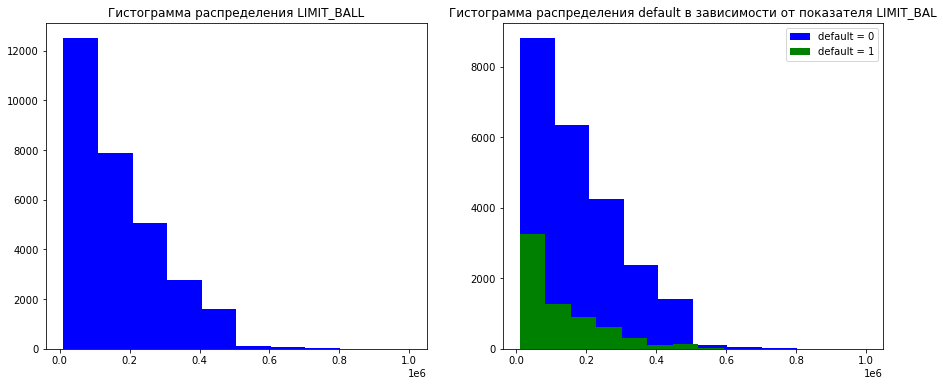

In [143]:
# посмотрим на распределение LIMIT_BAL
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('Гистограмма распределения LIMIT_BALL')
plt.hist(data['LIMIT_BAL'], color='b')

plt.subplot(1, 2, 2)
plt.title('Гистограмма распределения default в зависимости от показателя LIMIT_BAL')
plt.hist(data.LIMIT_BAL.loc[data.default == 0], color='b', label='default = 0')
plt.hist(data.LIMIT_BAL.loc[data.default == 1], color='g', label='default = 1')
plt.legend();

На втором графике можем отметить, что чаще всего не возвращают именно небольшие суммы.

Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки.
* Н0: медианные значения кредитного лимита равны
* Н1: медианные значения не равны

Для этого построим 95% доверительный интервал.

In [48]:
# Разобьем данные на две выборки
lim_return = data.LIMIT_BAL.loc[data.default == 0]
lim_default = data.LIMIT_BAL.loc[data.default == 1]

In [49]:
# Для проверки гипотезы воспользуемся bootstrap
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [50]:
np.random.seed(0)

lim_return_median_scores = list(map(np.median, get_bootstrap_samples(lim_return.values, 1000)))
lim_default_median_scores = list(map(np.median, get_bootstrap_samples(lim_default.values, 1000)))

print("95% confidence interval for lim_return:",  stat_intervals(lim_return_median_scores, 0.05))
print("95% confidence interval for lim_default:",  stat_intervals(lim_default_median_scores, 0.05))

95% confidence interval for lim_return: [150000. 150000.]
95% confidence interval for lim_default: [80000. 90000.]


Как мы видим, доверительные интервалы для медианных значений не совпадают. Следовательно на уровне значимости 0.05 нулевую гипотезу *отклоняем*. Что подтверждает наш вывод по графикам о разности суммы заема.

Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Уровень значимости 0.05
* Н0: распределения выборок равны
* Н1: распределения не равны

Так как у нас много повторяющихся значений, нам не подходит критерий Манна-Уитни. Следовательно, воспользуемся перестановочным критерием. 

In [55]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [56]:
print('p-value: %f' % permutation_test(lim_return, lim_default, max_permutations=1000))

p-value: 0.001000


При значение p-value = 0.01 нулевая гипотеза на уровне значимости 0.05 *отвергается*. 

#### Задание 2
Проверим гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.

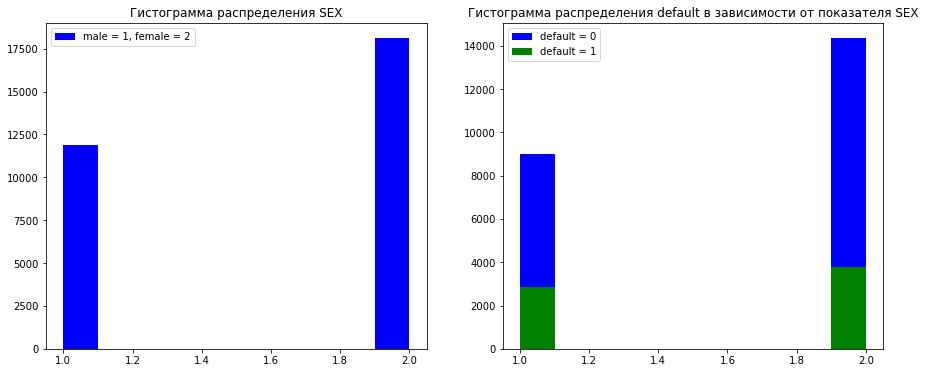

In [142]:
# визуализируем распределение признака SEX
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('Гистограмма распределения SEX')
plt.hist(data['SEX'], color='b', label='male = 1, female = 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Гистограмма распределения default в зависимости от показателя SEX')
plt.hist(data.SEX.loc[data.default == 0], color='b', label='default = 0')
plt.hist(data.SEX.loc[data.default == 1], color='g', label='default = 1')
plt.legend();

Видим, что женщины чаще мужчин берут кредит и реже возвращают его.

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.
* Н0: гендерный состав не отличается
* Н1: гендерный состав отличается

Уровень значимости 0.05.

Построим 95% доверительный интервал для доли вернувших/не вернувших кредит и их разности.

In [80]:
# разделим данные на две выборки
sex_return = data.SEX.loc[data.default == 0].values
sex_default = data.SEX.loc[data.default == 1].values

In [81]:
# воспользуемся доверительным интервалом для нормального распределения
normal_interval_return = proportion_confint(np.where(sex_return == 1)[0].shape[0],
                                            sex_return.shape[0], method = 'normal')
normal_interval_default = proportion_confint(np.where(sex_default == 1)[0].shape[0],
                                             sex_default.shape[0], method = 'normal')

print('normal_interval [%f, %f] for interval_return' % (normal_interval_return))
print('normal_interval [%f, %f] for interval_default' % (normal_interval_default))

normal_interval [0.379608, 0.392092] for interval_return
normal_interval [0.421020, 0.444863] for interval_default


Интервалы не пересекаются, следовательно, выборки по полу различаются.

In [89]:
# построим доверительный интервал для разности долей независимых выборок
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1. - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1. - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)


In [93]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(np.abs(sex_return-1), np.abs(sex_default-1)))

confidence interval: [0.033635, 0.060548]


Интервал не содержит ноль, то есть, при уровне значимости 0.05 можем опровергнуть нулевую гипотезу.

In [94]:
# проверим гипотезу с помощью z-критерия долей
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [108]:
proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(sex_return-2), np.abs(sex_default-2)))

4.472866521609831e-12

Значение p-value очень маленькое. Значит, что при уровне значимости 0.05 нулевая гипотеза отвергается. Таким образом, гендерный состав групп людей вернувших и не вернувших кредит отличается.

#### Задание 3

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Составим таблицу сопряженности "образование" на "возврат долга".

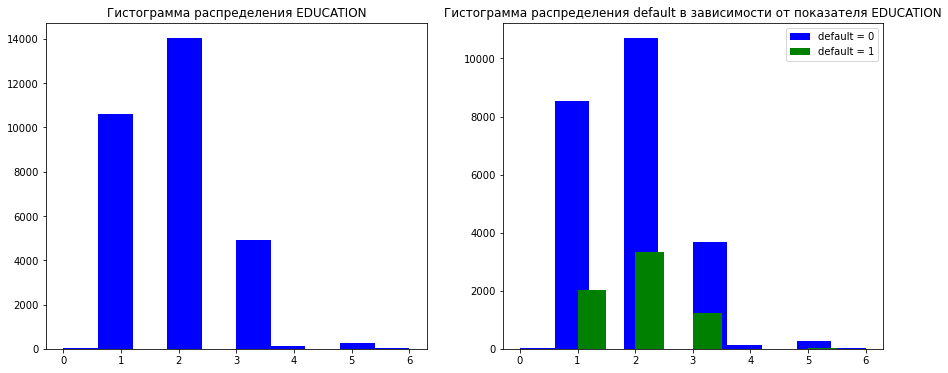

In [141]:
# посмотрим на распределение признака EDUCATION (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных)
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('Гистограмма распределения EDUCATION')
plt.hist(data['EDUCATION'], color='b')

plt.subplot(1, 2, 2)
plt.title('Гистограмма распределения default в зависимости от показателя EDUCATION')
plt.hist(data.EDUCATION.loc[data.default == 0], color='b', label='default = 0')
plt.hist(data.EDUCATION.loc[data.default == 1], color='g', label='default = 1')
plt.legend();

Чаще всего берут кредит люди с уровнем образования бакалавр и магистр, на 3-ем месте выпускники школы. Нельзя выделить кого-то отдельно в зависимости от возвращения долга.

In [116]:
# выделим выборки 
education_return = data.EDUCATION.loc[data.default == 0]
education_default = data.EDUCATION.loc[data.default == 1]
education = data.EDUCATION

In [126]:
# построим таблицу сопряженности
education_table = pd.pivot_table(data[['EDUCATION', 'default', 'LIMIT_BAL']],
                                 values=['LIMIT_BAL'], index=['EDUCATION'], columns=['default'],
                                 fill_value = 0, aggfunc='count')
education_table_matrix = np.matrix(education_table)

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг. 
* Н0: уровень образования влияет на возврат долга
* Н1: уровень образования не влияет.

Уровень значимости 0.05.

Так как признаки "EDUCATION" и "default" категориальные, можем посчитать меру взаимосвязи между ними
с помощью коэффициента V-Крамера.

In [151]:
def cramer_stat(matrix):
    chi_stat = stats.chi2_contingency(matrix)[0]
    k_min = np.min(matrix.shape)
    n = np.sum(matrix)
    return np.sqrt(chi_stat/(n*(k_min-1)))

In [135]:
print('V-Cramer statistic is: %.4f' % cramer_stat(education_table_matrix))

V-Cramer statistic is: 0.0738


In [138]:
print('p-value:', stats.chi2_contingency(education_table_matrix)[1])

p-value: 1.2332626245415605e-32


Можем сказать, что уровень образования влияет на возврат долга, но незначительно. Коэффициент V Крамера не очень велик, но p-value критерия хи-квадрат говорит нам, что это значение статистически значимо.

#### Задание 4

Проверим, как связан семейный статус с индикатором дефолта.

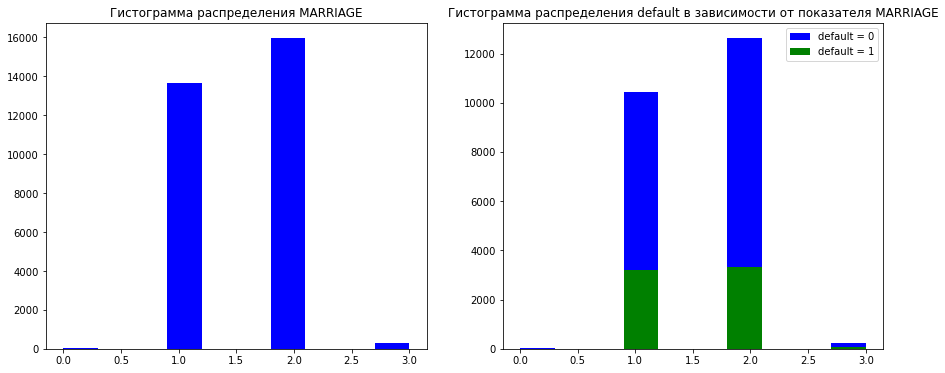

In [140]:
# построим гистограммы распределения признаков
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('Гистограмма распределения MARRIAGE')
plt.hist(data['MARRIAGE'], color='b')

plt.subplot(1, 2, 2)
plt.title('Гистограмма распределения default в зависимости от показателя MARRIAGE')
plt.hist(data.MARRIAGE.loc[data.default == 0], color='b', label='default = 0')
plt.hist(data.MARRIAGE.loc[data.default == 1], color='g', label='default = 1')
plt.legend();

Доли невозвратов в зависимости от семейного положения отличаются незначительно.

Проверим гипотезу о влиянии семейного положения на возврат кредита:
* Н0: семейное положение влияет на возврат кредита
* Н1: семейное положение не влияет 

Уровень значимости 0.05.

In [145]:
# выделим выборки 
marriage_return = data.MARRIAGE.loc[data.default == 0]
marriage_default = data.MARRIAGE.loc[data.default == 1]
marriage = data.MARRIAGE

In [147]:
# построим таблицу сопряженности
marriage_table = pd.pivot_table(data[['MARRIAGE', 'default', 'LIMIT_BAL']],
                                 values=['LIMIT_BAL'], index=['MARRIAGE'], columns=['default'],
                                 fill_value = 0, aggfunc='count')
marriage_table_matrix = np.matrix(marriage_table)

In [152]:
#вычислим коэффициент V Крамера
print('V-Cramer statistic is: %.4f' % cramer_stat(marriage_table_matrix))

V-Cramer statistic is: 0.0345


In [153]:
# вычислим значение хи-квадрат
print('p-value:', stats.chi2_contingency(marriage_table_matrix)[1])

p-value: 8.825862457577375e-08


Значение коэффициента V Крамера не велико, но p-value критерия хи-квадрат говорит нам, что это значение статистически значимо. Поэтому можем сказать, что значение признака MARRIAGE несущественно влияет на возврат долга. Значит, можем отклонить нулевую гипотезу.

#### Задание 5

Относительно двух групп людей  вернувших и не вернувших кредит  проверим следующие гипотезы:

a)  о равенстве медианных значений возрастов людей

b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

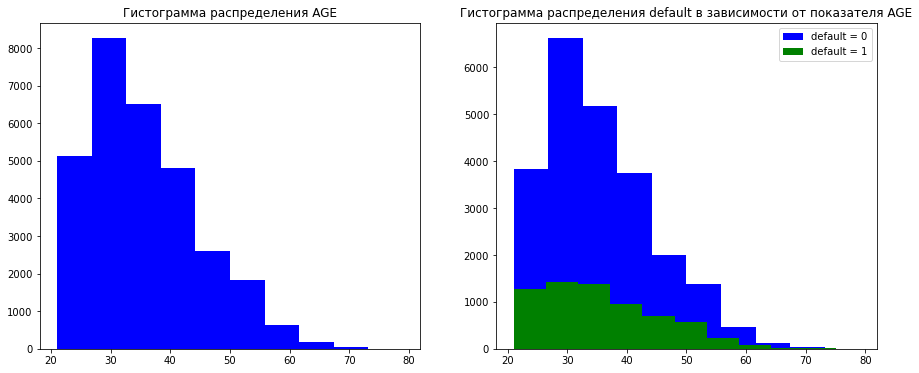

In [154]:
# построим гистограммы распределения признаков
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('Гистограмма распределения AGE')
plt.hist(data['AGE'], color='b')

plt.subplot(1, 2, 2)
plt.title('Гистограмма распределения default в зависимости от показателя AGE')
plt.hist(data.AGE.loc[data.default == 0], color='b', label='default = 0')
plt.hist(data.AGE.loc[data.default == 1], color='g', label='default = 1')
plt.legend();

По графику видим, что возраст влияет на возврат кредида — чем моложе заемщик, тем выше вероятность, что он не вернет кредит.

Проверим гипотезу о равенстве медианных значений возрастов людей:
* Н0: медианные значения возрастов равны
* Н1: медианные значения не равны

Уровень значимости 0.05.

In [155]:
# выделим выборки 
age_return = data.AGE.loc[data.default == 0]
age_default = data.AGE.loc[data.default == 1]
age = data.AGE

In [156]:
# построим доверительный интервал на основе бутстрепа
np.random.seed(0)

age_return_median_scores = list(map(np.median, get_bootstrap_samples(age_return.values, 1000)))
age_default_median_scores = list(map(np.median, get_bootstrap_samples(age_default.values, 1000)))

print("95% confidence interval for lim_return:",  stat_intervals(age_return_median_scores, 0.05))
print("95% confidence interval for lim_default:",  stat_intervals(age_default_median_scores, 0.05))

95% confidence interval for lim_return: [34. 34.]
95% confidence interval for lim_default: [34. 35.]


Интервальные оценки, как мы видим, пересекаются.

In [163]:
# построим интервальную оценку разности 
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(age_return_median_scores, age_default_median_scores)))
stat_int = stat_intervals(delta_median_scores, 0.05)
print('95%% confidence interval for difference between medians: [%f, %f]' % (stat_int[0], stat_int[1]))

95% confidence interval for difference between medians: [0.000000, 1.000000]


Так как доверительный интервал содержит ноль, мы не можем отклонить нулевую гипотезу. При уровне значимости 0.05 медианные значения равны.

Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.
* Н0: распределения равны
* Н1: распределения не равны

Уровень значимости 0.05.

В выборках много повторяющихся значений, поэтому стоит использовать перестановочный критерий для независимых выборок.

In [165]:
print('p-value: %f' % permutation_test(age_return, age_default, max_permutations=1000))

p-value: 0.014000


P-value довольно маленький, следовательно нулевая гипотеза отвергается на уровне значимости 0.05.

Таким образом, отметим характеристики, замеченный в случаях невозврата кредита: размер кредита, пол, с меньшим влиянием — уровень образования и семейное положение.